In [ ]:
import csv
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random

from scipy.special import logsumexp  # to deal with potential overflow issues


def set_seed(seed):  # For reproducibility, fix random seeds.
  random.seed(seed)
  np.random.seed(seed)

set_seed(42)

# Fashion MNIST

Download the Fashion MNIST dataset from [here](https://drive.google.com/drive/folders/1BnU7wVriolasZAZ1bSDTyll1Tp61hP1c?usp=sharing). It consists of 16 x 16 grayscale images (downsized from 28 x 28 for efficiency), split into 50,000 training and 10,000 validation images. Each image is labeled as one of 10 clothing categories (e.g., dress, sandal, shirt). We will assume that we have the directory `data/FashionMNIST/` in our Google Drive account. Let's load the data and stare at it.  

In [ ]:
# Load the Drive helper and mount. You will have to authorize this operation. 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
datadir = '/content/drive/My Drive/data/FashionMNIST/'
# datadir = 'Desktop/FashionMNIST/'
label_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']  # Hardcoded

class FashionMNIST:

  def __init__(self, split):
    assert split in ['Tr', 'Vl']  # We don't have a test set
    self.inputs = np.load('{:s}x{:s}.npy'.format(datadir, split))  # (N, 16^2)
    self.labels = np.load('{:s}y{:s}.npy'.format(datadir, split))  # (N, 10)
    self.num_examples, self.dim = self.inputs.shape
    self.num_labels = self.labels.shape[1]

    # Partition data by labels
    self.partition = [self.inputs[np.where(np.argmax(self.labels, axis=1) == y)[0]] for y in range(self.num_labels)]

In [ ]:
data_train = FashionMNIST('Tr')
data_val = FashionMNIST('Vl')

print(data_train.inputs.shape, data_val.inputs.shape)

(50000, 256) (10000, 256)


In [ ]:
def show_image(image, ax=None):
  width = int(np.sqrt(image.shape[0]))
  image = image.reshape(width, width)  
  if ax == None:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
  imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
  imgplot.set_interpolation('nearest')
  ax.xaxis.set_ticks_position('top')
  ax.yaxis.set_ticks_position('left')
  plt.axis('off')

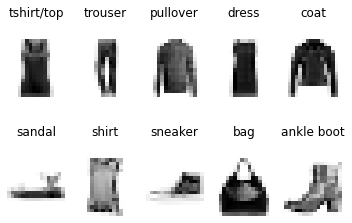

In [ ]:
for y in range(10):
  ax = plt.subplot(2, 5, y + 1)
  ax.clear()
  show_image(data_train.partition[y][0], ax)
  ax.set_title(label_names[y])

The images are a little blurry because we downsized them, but they will do. 

# Gaussian Mixture Model (GMM)

A **Gaussian mixture model** (GMM) with $K$ components has learnable parameters $\pi \in \mathbb{R}^K$ and $\mu_k \in \mathbb{R}^K, \Sigma_k \in \mathbb{R}^{K \times K}$ for each $k = 1 \ldots K$, where it is always assumed that 

- $\pi$ is a (full-support) distribution over the $K$ components. So $\pi_k > 0$ and $\sum_{k=1}^K \pi_k = 1$. 
- $\Sigma_k$ is a symmetric and positive definite (thus invertible) for each $k$. 

A GMM  defines a joint distribution over $k \in \{1 \ldots K\}$ and $x \in \mathbb{R}^d$ by 
$$
p(k,x) = \pi_k \times \mathcal{N}(\mu_k, \Sigma_k)(x)
$$
where $\mathcal{N}(\mu_k, \Sigma_k)(x)$ is the probability of $x$ under the Gaussian distribution with mean $\mu_k$ and covariance matrix $\Sigma_k$. For practical reasons, we do the following:  

- We optionally restrict ourselves to *diagonal* covariance matrices to make calculation simpler and more efficient.
- We work in *log space* for numerical stability, that is: $\log p(k,x) = \log \pi_k + \log \mathcal{N}(\mu_k, \Sigma_k)(x)$. 
- We make all variables multidimensional tensors so that we can use linear algebraic operations instead of for loops. 

In [ ]:
class GMM:

  def __init__(self, dim, num_components, diag=False):
    self.pi = np.full(num_components, 1. / num_components)  # (K,)
    self.mu = np.zeros((num_components, dim))  # (K, d)
    if diag:
      self.sigma = np.ones((num_components, dim))  # (K, d)
    else:   
      self.sigma = np.array([np.identity(dim) for _ in range(num_components)])   # (K, d, d)
    self.diag = diag

  def compute_log_probs(self, inputs):  # (N, d)
    log_pi = np.log(self.pi)[:, np.newaxis]  # (K, 1)
    diffs = inputs[np.newaxis, :, :] - self.mu[:, np.newaxis, :]  # (K, N, d)

    # TODO: implement, do not use for loops
    d = inputs.shape[1]
    # print("d is ", d)
    K = diffs.shape[0]
    # print("K is ", K)
    N = diffs.shape[1]
    # print("N is ", N)
    constant = np.full([K, N], (-1/2)*np.log(np.power(2*np.pi, d))) #(K,N)
    if self.diag:
      # self.sigma[5][7] = 0.0
      # print("self.sigma is ", self.sigma)
      sigma_inv = np.matrix.copy(self.sigma)
      mask = sigma_inv != 0
      sigma_inv[mask] = 1/sigma_inv[mask]
      # sigma_inv = 1/self.sigma
      expand_sigma_inv = sigma_inv[:, np.newaxis,:]
      # print("expand_sigma ", expand_sigma_inv.shape)
      diff_trans = np.multiply(diffs,expand_sigma_inv)
      # print("diff shape ", diff_trans.shape)
      diff_trans = np.sum(diff_trans*diffs, axis=2)
      # print("result shape is ", diff_trans.shape)
      log_probs = log_pi + constant + (-1/2)*(np.sum(np.log(self.sigma), 1))[:,np.newaxis]+ (-1/2)*diff_trans  # (K, N): log p(k, inputs[i])
      # print("shape is ", log_probs.shape)
    else:
      sign, det = np.linalg.slogdet(self.sigma)
      # print("det is ", det.shape)
      temp = np.matmul(diffs, np.linalg.pinv(self.sigma))
      # print("temp is ", temp.shape)
      log_probs = log_pi + constant + (-1/2)*det[:,np.newaxis] + np.sum((-1/2)*np.matmul(diffs, np.linalg.pinv(self.sigma))*diffs, axis=2)
    return log_probs  

  def compute_posteriors(self, inputs):  # (N, d)
    log_probs = self.compute_log_probs(inputs)  # (K, N): log p(k, x)
    marginal_log_probs = logsumexp(log_probs, axis=0)  # (N,): log p(x)
    marginal_log_likelihood = marginal_log_probs.mean()  # Scalar
    posteriors = np.exp(log_probs - marginal_log_probs[np.newaxis, :])  # (K, N): p(k|x)
    return posteriors, marginal_log_likelihood, marginal_log_probs

In [ ]:
import unittest

from scipy.stats import multivariate_normal 

class TestGMM(unittest.TestCase):
      
  def setUp(self):
    set_seed(42)
    self.dim = 100
    self.num_components = 7
    self.num_examples = 200
    self.power = 2 # Check for numerical stability

    self.inputs = np.random.randn(self.num_examples, self.dim)

  def test_model_diag(self): 
    model = self.init_model(diag=True)
    log_probs_gold = self.get_log_probs_gold(model)
    log_probs = model.compute_log_probs(self.inputs)
    for k in range(self.num_components):
      for i in range(self.num_examples):
        self.assertAlmostEqual(log_probs[k, i], log_probs_gold[k, i])

  def test_model_nondiag(self): 
    model = self.init_model(diag=False)
    log_probs_gold = self.get_log_probs_gold(model)
    log_probs = model.compute_log_probs(self.inputs)
    for k in range(self.num_components):
      for i in range(self.num_examples):
        self.assertAlmostEqual(log_probs[k, i], log_probs_gold[k, i])

  def get_log_probs_gold(self, model):
    log_probs_gold = []
    for k in range(self.num_components):
      dist = multivariate_normal(mean=model.mu[k], cov=(np.diag(model.sigma[k]) if model.diag else model.sigma[k]))
      log_probs_gold.append([np.log(model.pi[k]) + dist.logpdf(self.inputs[i]) for i in range(self.num_examples)])
    return np.array(log_probs_gold)

  def init_model(self, diag=False):
    model = GMM(self.dim, self.num_components, diag=diag)
    pi_unnormalized = np.random.uniform(size=(self.num_components,)) ** self.power
    model.pi = pi_unnormalized / pi_unnormalized.sum()
    model.mu = np.random.randn(self.num_components, self.dim) ** self.power 
    if diag:
      model.sigma = np.random.randn(self.num_components, self.dim) ** self.power
    else:
      model.sigma = np.array([np.diag(np.random.randn(self.dim)) ** self.power for _ in range(self.num_components)])
    return model
            
unittest.main(TestGMM(), argv=[''], verbosity=2, exit=False)

test_model_diag (__main__.TestGMM) ... ok
test_model_nondiag (__main__.TestGMM) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.175s

OK


# Expectation Maximization (EM)

The EM algorithm trains a GMM on *unlabeled* data by alternating the E step and the M step:
- E step: Compute posteriors $p(k|x_i)$ for every training input $i = 1 \ldots N$ and label $k = 1\ldots K$. This needs an initial set of parameter values.
- M step: Calculate the maximum-likelihood estimate of parameters under the posteriors.


In [ ]:
class GMMTrainerEM:

  def __init__(self, model, smoothing=0.1):
    self.model = model
    self.smoothing = smoothing
    self.diag_smoother =  smoothing * np.array([np.identity(model.mu.shape[1]) for _ in range(model.mu.shape[0])])

  def train(self, inputs, num_iterations_max=40, verbose=False, init_method='naive'):
    self.init_centers(inputs, init_method=init_method)
    mll_previous = -np.inf 
    posteriors, mll, _ = self.model.compute_posteriors(inputs)  # E step
    for iteration in range(num_iterations_max): 
      self.update_parameters(inputs, posteriors)  # M step
      posteriors, mll, _ = self.model.compute_posteriors(inputs)  # E step
      if verbose:
        print('Iteration {:3d}:\t marginal log-likelihood {:10.4f}'.format(iteration + 1,  mll))
      if np.isclose(mll, mll_previous):
        break
      mll_previous = mll
    return mll, iteration

  def update_parameters(self, inputs, posteriors):
    expected_counts = posteriors.sum(axis=1) + self.smoothing # (K,)
    self.model.pi = expected_counts / expected_counts.sum()

    weighted_sums = posteriors @ inputs  # (K, d)
    self.model.mu = weighted_sums / expected_counts[:, np.newaxis]

    diffs = inputs[np.newaxis, :, :] - self.model.mu[:, np.newaxis, :]  # (K, N, d)
    diffs_weighted = posteriors[:, :, np.newaxis] * diffs  # (K, N, d)

    # print("---------self.diag_smoother  is \n", self.diag_smoother.shape)
    # print("---------self.model.sigma shape is ", (np.sum((diffs_weighted*diffs), axis=1)/expected_counts[:,np.newaxis]).shape)
    if self.model.diag:
      self.model.sigma = np.sum((diffs_weighted*diffs), axis=1)/expected_counts[:,np.newaxis] # TODO: Implement
      diagnol = np.diagonal(self.diag_smoother, axis1=1, axis2=2)
      # mask = self.model.sigma < self.smoothing
      # print("-------------sigma shape is ", self.model.sigma.shape)
      # print("-------------diagnol's shape is \n", diagnol.shape)
      # sigma1 = np.copy(self.model.sigma)
      mask = np.abs(self.model.sigma) < np.abs(self.smoothing)
      self.model.sigma[mask] = diagnol[mask]
      # for i in range(sigma1.shape[0]):
      #   for j in range(sigma1.shape[1]):
      #     if self.model.sigma[i][j] == sigma1[i][j]:
      #       print("sigma1 is ", sigma1[i][j])
      #       print("selfsigma is ", self.model.sigma[i][j])
      # print("-------------numerator is ", np.sum((diffs_weighted*diffs), axis=1))
      # print("-------------denominator is ", expected_counts)
      # print("-------------------------sigma is updated as ", self.model.sigma)
      # print("sigma shape is ", self.model.sigma.shape)
    else:
      # print("-------------sigma shape is ", self.model.sigma.shape)
      self.model.sigma = np.matmul(np.transpose(diffs_weighted, axes=(0,2,1)), diffs)/expected_counts[:,np.newaxis, np.newaxis] # TODO: Implement
      # print("-------------sigma shape is ", self.model.sigma.shape)
      # sigma1 = np.copy(self.model.sigma)
      # mask = self.model.sigma < self.smoothing
      # print("smoother is \n", self.diag_smoother)
      # print("mask is ", mask)
      # print("smoothing is ", self.smoothing)
      # mask = np.abs(self.model.sigma) < np.abs(self.diag_smoother)
      self.model.sigma = self.model.sigma + self.diag_smoother
      # for i in range(sigma1.shape[0]):
      #   for j in range(sigma1.shape[1]):
      #     for k in range(sigma1.shape[2]):
      #       if self.model.sigma[i][j][k] != sigma1[i][j][k]:
      #         print("sigma1 is ", sigma1[i][j][k])
      #         print("selfsigma is ", self.model.sigma[i][j][k])
      # diagonal = np.diagnal(self.model.sigma, axis1=1, axis2=2)
      # print("sigma shape is ", self.model.sigma.shape)
    
  def init_centers(self, inputs, init_method='naive'):
    # Find K centers from the given input vectors (N, d) somehow.
    if init_method == 'naive':

      # TODO: Implement
      # Tip: try selecting a random input as the first center, then iteratively selecting argmax_i sum_{l<k} ||x_l - x_i||
      rand_indx = np.random.randint(0, inputs.shape[0])
      mu1 = inputs[rand_indx]
      assert mu1.all() == inputs[rand_indx].all()
      # print("inputs shape is ", inputs.shape)

      self.model.mu[0] = mu1
      # print(self.model.mu)
      sum = np.zeros(inputs.shape[0])
      for k in range(1, self.model.mu.shape[0]):
        norm = np.linalg.norm((self.model.mu[k-1][np.newaxis, :] - inputs), axis=1)
        # print("---------norm shape is ", norm.shape)
        # norm = np.sum(np.abs(self.model.mu[k-1][np.newaxis, :] - inputs), axis=1)
        sum = sum + norm
        # print("------------sum is ", sum.shape)
        newmu_index = np.where(sum == np.amax(sum))
        # print("============newmu is ", newmu_index)
        self.model.mu[k] = inputs[newmu_index]


    else: 
      raise ValueError('Unknown init method: ' + init_method)

# Experiments with Diagonal GMMs

We can use GMMs for classification, by training a GMM for each input partition with the same label then at test time predicting the label corresponding to the GMM with highest *marginal* likelihood.

In [ ]:
def compute_accuracy(models, data):  # models[y]: GMM for label y
  log_probs_all = np.zeros((data.num_examples, data.num_labels))
  # print("data is shape ", data.shape)
  for y in range(data.num_labels):
    # print("log_probs_all shape is ", log_probs_all[:,y])
    assert (log_probs_all[:,y].shape == logsumexp(models[y].compute_log_probs(data.inputs), axis=0).shape)
    log_probs_all[:, y] = logsumexp(models[y].compute_log_probs(data.inputs), axis=0)  # TODO: Implement
  # print("log_probs size is ", log_probs_all.shape)
  # print()
  preds = np.argmax(log_probs_all, axis=1)
  acc = np.mean(preds == np.argmax(data.labels, axis=1)) * 100.
  return acc, preds

One cool thing is that each mean $\mu_k$ corresponding to component $k$ can be visualized. We will hypothesize that different components learn different representations of the same label.

In [ ]:
def show_means(models, y):
  num_components = len(models[y].pi)
  fig, axes = plt.subplots(1, num_components)

  for k in range(num_components):
    if num_components == 1:
      ax = axes
    else:
      ax = axes[k]
    show_image(models[y].mu[k], ax)
    ax.axis("off")
    if k == 0:
      ax.set_title(label_names[y] + "/" + str(k))
    else:
      ax.set_title("/" + str(k))
  return fig, axes

We're ready to train diagonal GMMs with various $K$ values. The training is pretty sensitive to the smoothing parameter so be careful. 

***Training a diagonal GMM with K=1 components***
Label 0:  1 iterations, final MLL      4.100
Label 1:  1 iterations, final MLL     28.219
Label 2:  1 iterations, final MLL     -3.413
Label 3:  1 iterations, final MLL     13.601
Label 4:  1 iterations, final MLL      4.029
Label 5:  1 iterations, final MLL      9.074
Label 6:  1 iterations, final MLL     -5.963
Label 7:  1 iterations, final MLL     28.665
Label 8:  1 iterations, final MLL    -24.045
Label 9:  1 iterations, final MLL      5.658
K=1: acc train 67.83, acc val 67.47


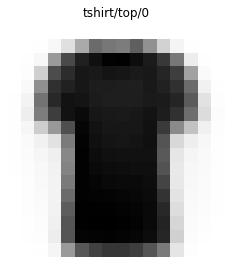

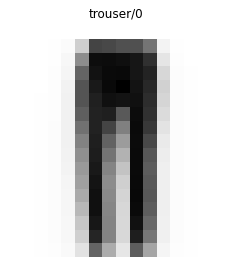

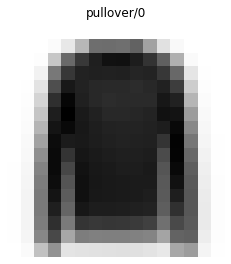

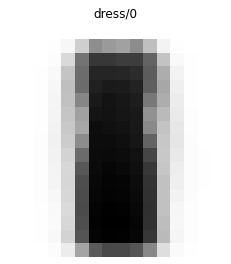

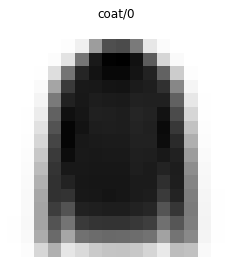

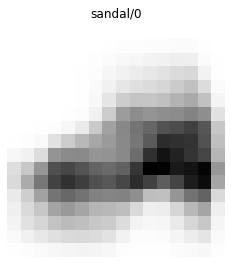

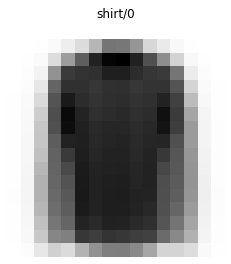

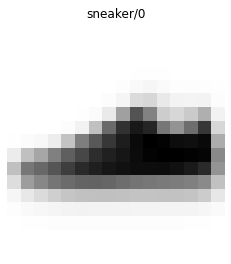

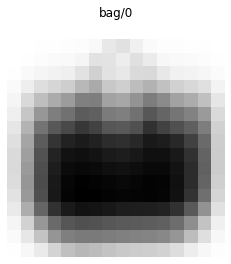

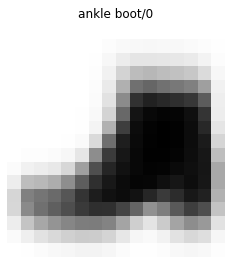

***Training a diagonal GMM with K=2 components***
Label 0: 13 iterations, final MLL     22.812
Label 1: 35 iterations, final MLL     33.653
Label 2: 11 iterations, final MLL     18.476
Label 3: 10 iterations, final MLL     24.391
Label 4: 24 iterations, final MLL     17.619
Label 5: 13 iterations, final MLL     17.011
Label 6:  6 iterations, final MLL     15.977
Label 7: 22 iterations, final MLL     34.667
Label 8: 23 iterations, final MLL     -5.018
Label 9: 16 iterations, final MLL     18.924
K=2: acc train 71.93, acc val 71.30


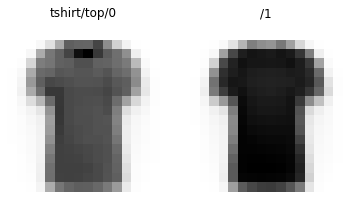

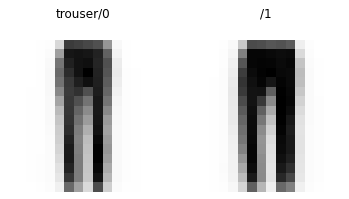

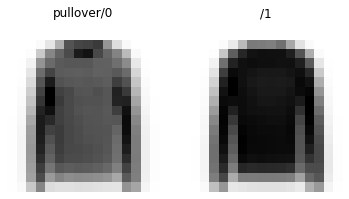

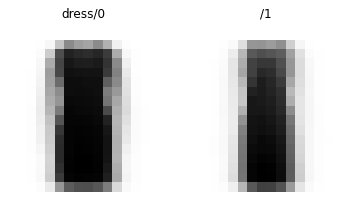

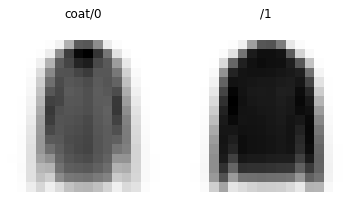

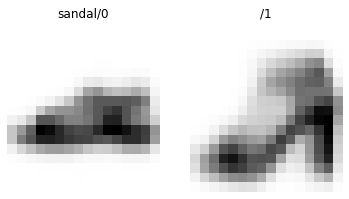

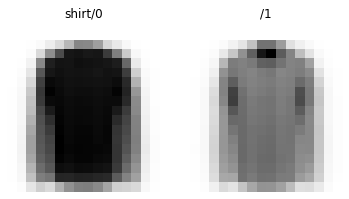

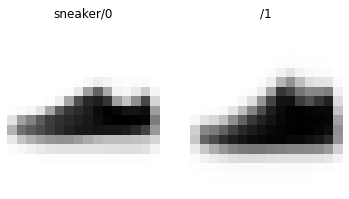

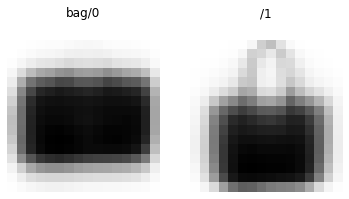

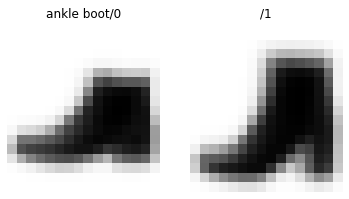

***Training a diagonal GMM with K=3 components***
Label 0: 39 iterations, final MLL     26.434
Label 1: 39 iterations, final MLL     36.739
Label 2: 15 iterations, final MLL     22.995
Label 3: 12 iterations, final MLL     28.644
Label 4: 15 iterations, final MLL     24.351
Label 5: 28 iterations, final MLL     19.792
Label 6: 11 iterations, final MLL     22.054
Label 7: 12 iterations, final MLL     37.056
Label 8: 30 iterations, final MLL      4.352
Label 9: 26 iterations, final MLL     23.395
K=3: acc train 73.98, acc val 73.28


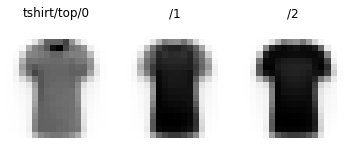

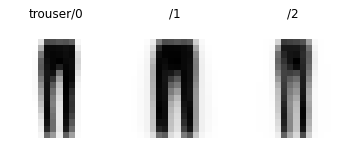

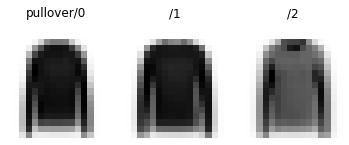

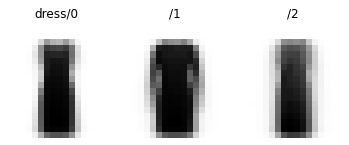

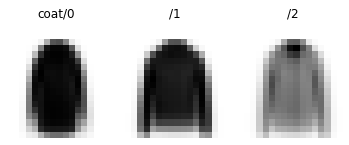

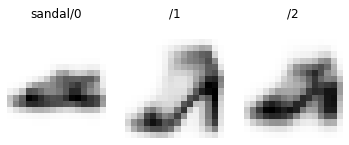

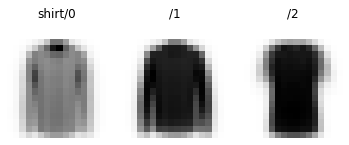

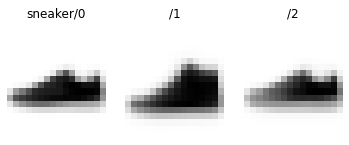

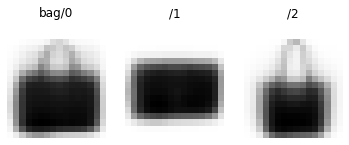

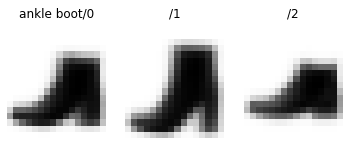

***Training a diagonal GMM with K=4 components***
Label 0: 36 iterations, final MLL     28.211
Label 1: 32 iterations, final MLL     38.775
Label 2: 39 iterations, final MLL     25.841
Label 3: 39 iterations, final MLL     30.603
Label 4: 39 iterations, final MLL     26.770
Label 5: 26 iterations, final MLL     22.080
Label 6: 20 iterations, final MLL     25.191
Label 7: 25 iterations, final MLL     39.110
Label 8: 36 iterations, final MLL      9.810
Label 9: 28 iterations, final MLL     25.497
K=4: acc train 75.16, acc val 74.10


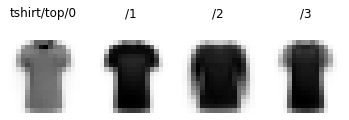

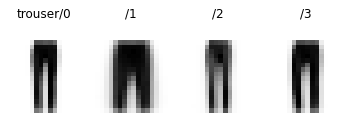

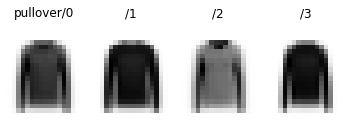

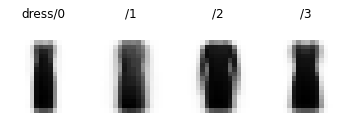

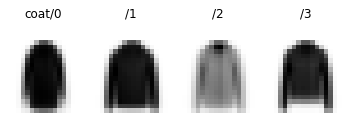

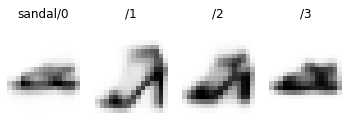

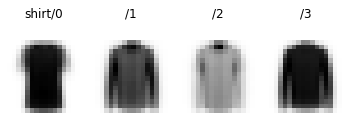

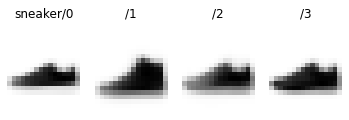

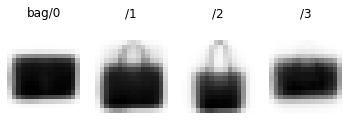

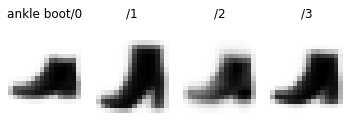

***Training a diagonal GMM with K=5 components***
Label 0: 36 iterations, final MLL     30.501
Label 1: 20 iterations, final MLL     39.706
Label 2: 22 iterations, final MLL     27.743
Label 3: 39 iterations, final MLL     31.839
Label 4: 19 iterations, final MLL     29.218
Label 5: 28 iterations, final MLL     23.758
Label 6: 14 iterations, final MLL     26.912
Label 7: 19 iterations, final MLL     39.888
Label 8: 21 iterations, final MLL     13.550
Label 9: 20 iterations, final MLL     26.945
K=5: acc train 76.37, acc val 75.45


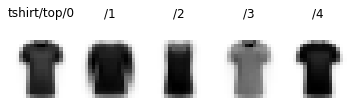

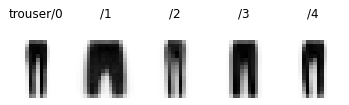

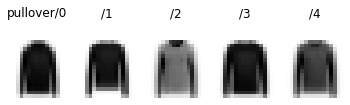

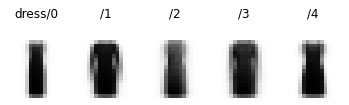

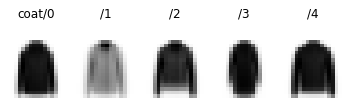

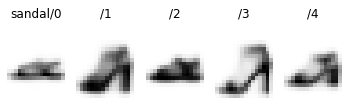

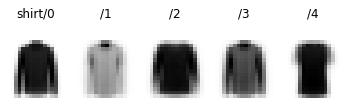

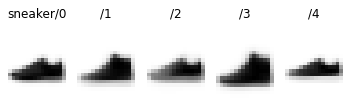

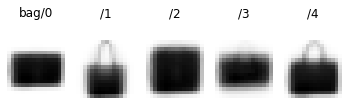

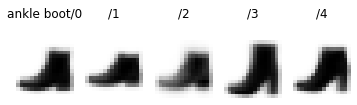

***Training a diagonal GMM with K=6 components***
Label 0: 39 iterations, final MLL     31.546
Label 1: 39 iterations, final MLL     41.072
Label 2: 23 iterations, final MLL     28.785
Label 3: 16 iterations, final MLL     32.896
Label 4: 19 iterations, final MLL     30.867
Label 5: 29 iterations, final MLL     24.493
Label 6: 24 iterations, final MLL     27.900
Label 7: 39 iterations, final MLL     40.260
Label 8: 39 iterations, final MLL     14.304
Label 9: 23 iterations, final MLL     28.249
K=6: acc train 77.16, acc val 76.77


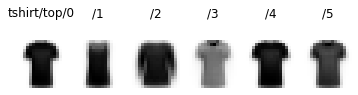

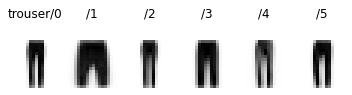

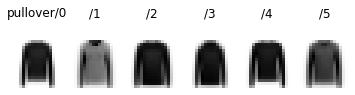

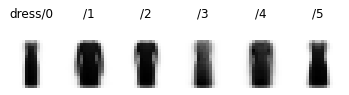

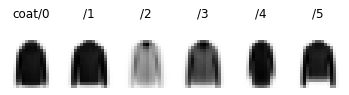

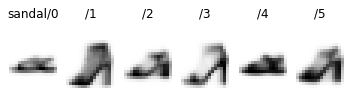

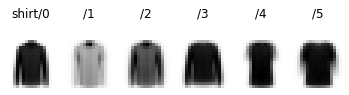

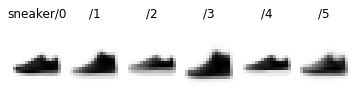

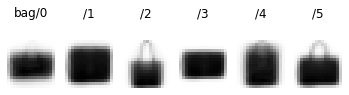

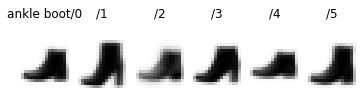

***Training a diagonal GMM with K=7 components***
Label 0: 39 iterations, final MLL     32.012
Label 1: 32 iterations, final MLL     41.388
Label 2: 31 iterations, final MLL     29.715
Label 3: 29 iterations, final MLL     33.594
Label 4: 39 iterations, final MLL     31.709
Label 5: 38 iterations, final MLL     25.101
Label 6: 39 iterations, final MLL     29.155
Label 7: 19 iterations, final MLL     40.476
Label 8: 26 iterations, final MLL     17.325
Label 9: 25 iterations, final MLL     28.955
K=7: acc train 77.69, acc val 76.88


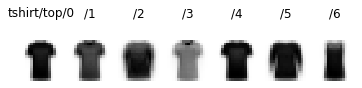

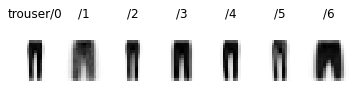

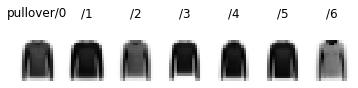

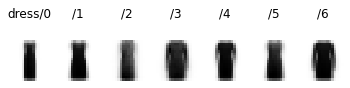

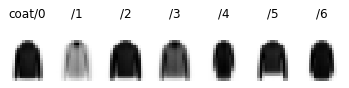

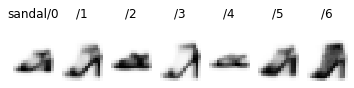

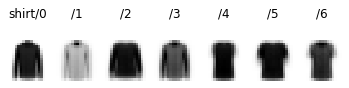

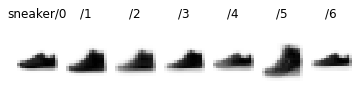

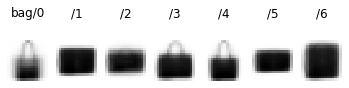

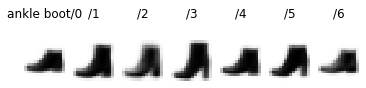

***Training a diagonal GMM with K=8 components***
Label 0: 39 iterations, final MLL     31.444
Label 1: 36 iterations, final MLL     41.388
Label 2: 18 iterations, final MLL     30.717
Label 3: 39 iterations, final MLL     34.280
Label 4: 39 iterations, final MLL     32.179
Label 5: 39 iterations, final MLL     25.800
Label 6: 28 iterations, final MLL     29.583
Label 7: 36 iterations, final MLL     40.930
Label 8: 39 iterations, final MLL     17.967
Label 9: 26 iterations, final MLL     30.592
K=8: acc train 78.08, acc val 77.60


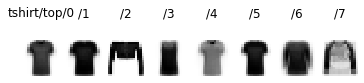

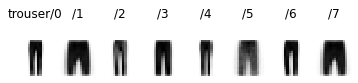

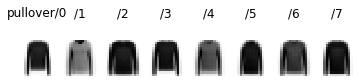

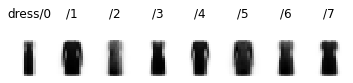

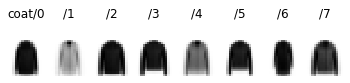

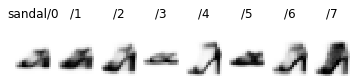

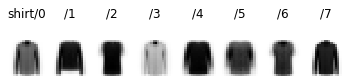

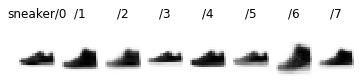

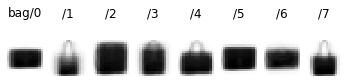

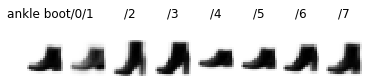

***Training a diagonal GMM with K=9 components***
Label 0: 39 iterations, final MLL     31.664
Label 1: 20 iterations, final MLL     41.915
Label 2: 38 iterations, final MLL     31.257
Label 3: 28 iterations, final MLL     34.847
Label 4: 39 iterations, final MLL     33.215
Label 5: 39 iterations, final MLL     26.752
Label 6: 18 iterations, final MLL     30.381
Label 7: 39 iterations, final MLL     41.138
Label 8: 39 iterations, final MLL     19.856
Label 9: 31 iterations, final MLL     31.029
K=9: acc train 78.77, acc val 77.88


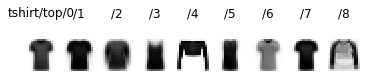

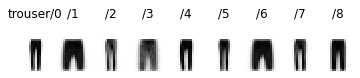

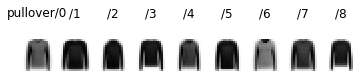

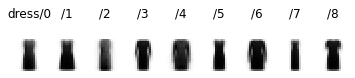

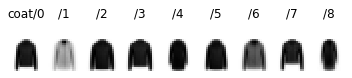

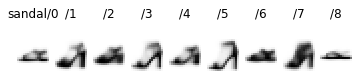

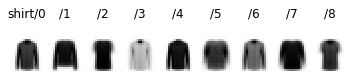

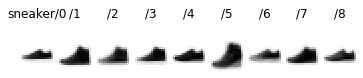

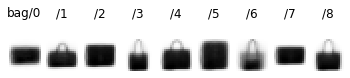

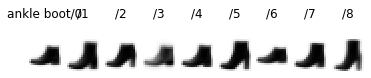

***Training a diagonal GMM with K=10 components***
Label 0: 39 iterations, final MLL     32.977
Label 1: 25 iterations, final MLL     42.321
Label 2: 36 iterations, final MLL     31.756
Label 3: 31 iterations, final MLL     35.334
Label 4: 39 iterations, final MLL     33.688
Label 5: 39 iterations, final MLL     27.053
Label 6: 26 iterations, final MLL     31.162
Label 7: 39 iterations, final MLL     41.273
Label 8: 39 iterations, final MLL     19.271
Label 9: 23 iterations, final MLL     31.561
K=10: acc train 79.14, acc val 78.21


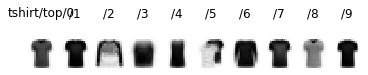

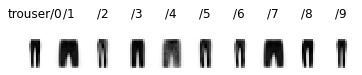

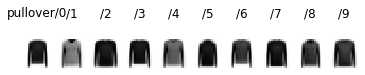

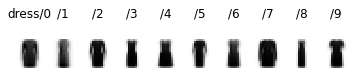

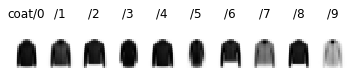

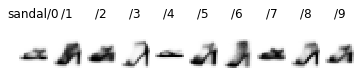

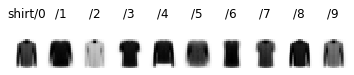

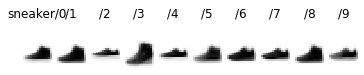

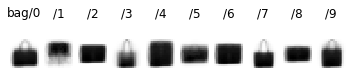

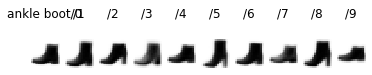

***Training a diagonal GMM with K=11 components***
Label 0: 39 iterations, final MLL     32.782
Label 1: 39 iterations, final MLL     42.362
Label 2: 35 iterations, final MLL     32.237
Label 3: 39 iterations, final MLL     35.607
Label 4: 39 iterations, final MLL     33.714
Label 5: 39 iterations, final MLL     26.757
Label 6: 39 iterations, final MLL     31.065
Label 7: 39 iterations, final MLL     41.510
Label 8: 39 iterations, final MLL     20.547
Label 9: 21 iterations, final MLL     32.049
K=11: acc train 79.16, acc val 77.72


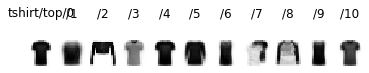

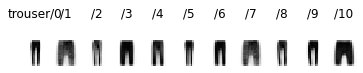

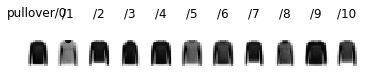

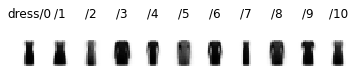

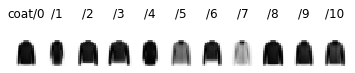

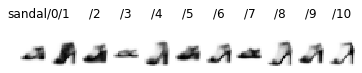

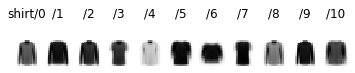

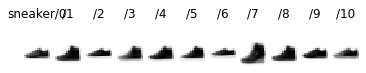

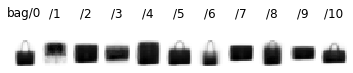

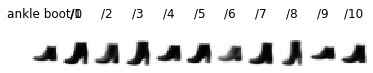

***Training a diagonal GMM with K=12 components***
Label 0: 39 iterations, final MLL     33.349
Label 1: 36 iterations, final MLL     42.439
Label 2: 26 iterations, final MLL     32.229
Label 3: 34 iterations, final MLL     35.888
Label 4: 39 iterations, final MLL     34.392
Label 5: 39 iterations, final MLL     27.817
Label 6: 39 iterations, final MLL     31.653
Label 7: 39 iterations, final MLL     41.741
Label 8: 39 iterations, final MLL     21.724
Label 9: 32 iterations, final MLL     32.442
K=12: acc train 79.65, acc val 78.60


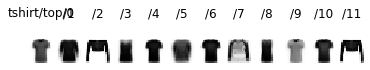

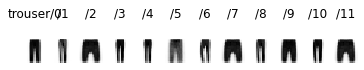

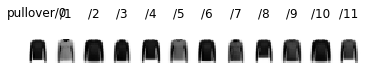

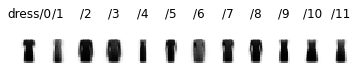

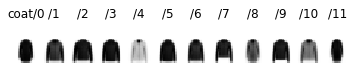

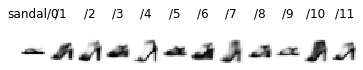

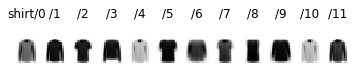

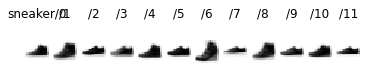

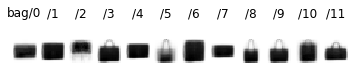

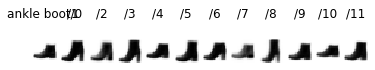

***Training a diagonal GMM with K=13 components***
Label 0: 33 iterations, final MLL     33.250
Label 1: 39 iterations, final MLL     42.848
Label 2: 39 iterations, final MLL     33.055
Label 3: 39 iterations, final MLL     36.037
Label 4: 39 iterations, final MLL     34.802
Label 5: 39 iterations, final MLL     27.792
Label 6: 32 iterations, final MLL     31.941
Label 7: 20 iterations, final MLL     41.864
Label 8: 39 iterations, final MLL     22.128
Label 9: 31 iterations, final MLL     32.769
K=13: acc train 79.41, acc val 77.83


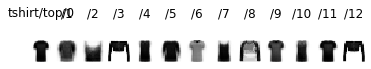

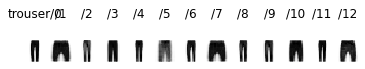

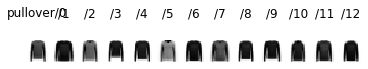

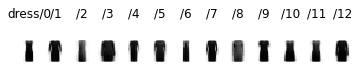

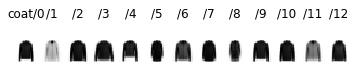

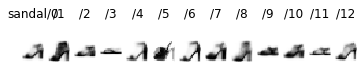

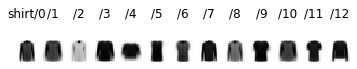

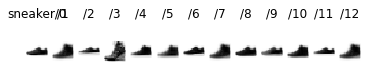

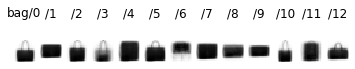

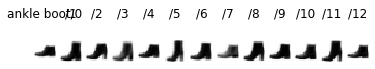

***Training a diagonal GMM with K=14 components***
Label 0: 39 iterations, final MLL     33.931
Label 1: 39 iterations, final MLL     42.842
Label 2: 39 iterations, final MLL     33.090
Label 3: 39 iterations, final MLL     36.435
Label 4: 39 iterations, final MLL     34.739
Label 5: 39 iterations, final MLL     28.590
Label 6: 39 iterations, final MLL     32.351
Label 7: 28 iterations, final MLL     42.375
Label 8: 39 iterations, final MLL     22.788
Label 9: 28 iterations, final MLL     32.983
K=14: acc train 80.04, acc val 78.83


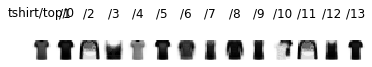

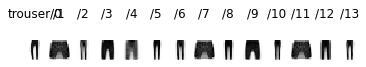

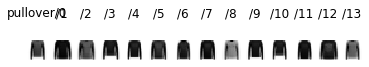

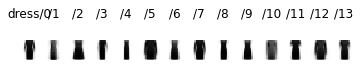

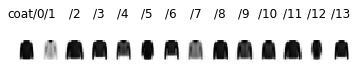

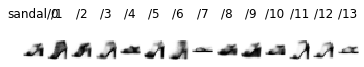

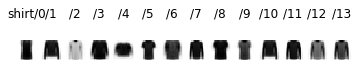

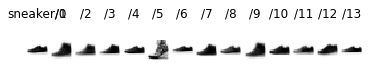

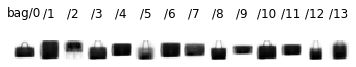

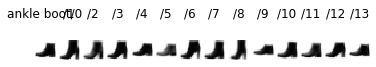

***Training a diagonal GMM with K=15 components***
Label 0: 38 iterations, final MLL     33.556
Label 1: 39 iterations, final MLL     43.319
Label 2: 33 iterations, final MLL     33.064
Label 3: 39 iterations, final MLL     36.536
Label 4: 39 iterations, final MLL     35.283
Label 5: 39 iterations, final MLL     28.624
Label 6: 39 iterations, final MLL     32.624
Label 7: 39 iterations, final MLL     42.200
Label 8: 39 iterations, final MLL     23.467
Label 9: 39 iterations, final MLL     33.079
K=15: acc train 80.33, acc val 78.82


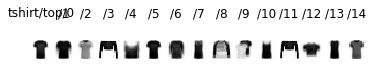

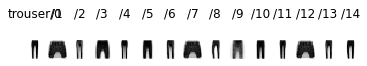

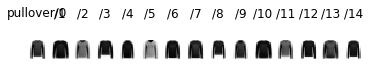

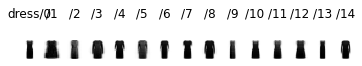

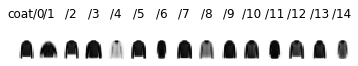

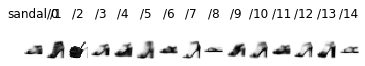

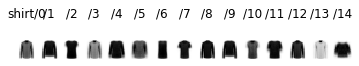

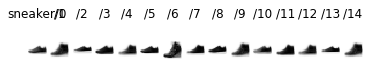

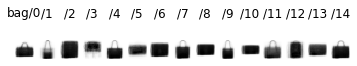

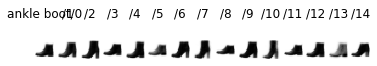

***Training a diagonal GMM with K=16 components***
Label 0: 35 iterations, final MLL     33.607
Label 1: 29 iterations, final MLL     43.083
Label 2: 29 iterations, final MLL     33.370
Label 3: 39 iterations, final MLL     36.583
Label 4: 39 iterations, final MLL     35.462
Label 5: 39 iterations, final MLL     28.770
Label 6: 39 iterations, final MLL     32.597
Label 7: 24 iterations, final MLL     42.372
Label 8: 39 iterations, final MLL     24.079
Label 9: 39 iterations, final MLL     33.297
K=16: acc train 80.10, acc val 78.21


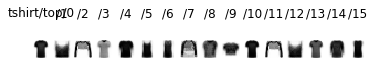

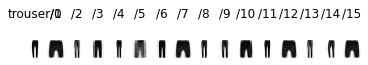

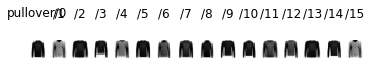

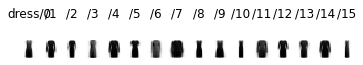

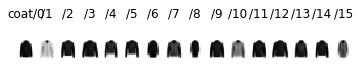

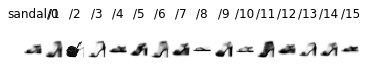

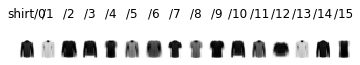

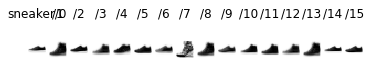

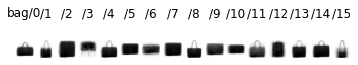

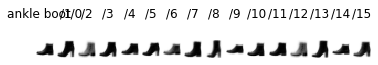

***Training a diagonal GMM with K=17 components***
Label 0: 23 iterations, final MLL     33.970
Label 1: 39 iterations, final MLL     43.120
Label 2: 39 iterations, final MLL     33.523
Label 3: 39 iterations, final MLL     36.740
Label 4: 39 iterations, final MLL     35.431
Label 5: 39 iterations, final MLL     28.910
Label 6: 32 iterations, final MLL     32.748
Label 7: 39 iterations, final MLL     42.470
Label 8: 37 iterations, final MLL     23.465
Label 9: 39 iterations, final MLL     33.403
K=17: acc train 80.33, acc val 78.51


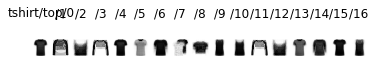

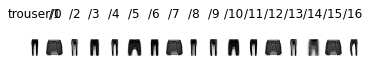

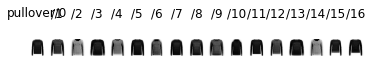

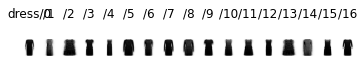

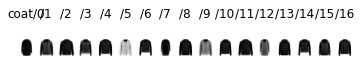

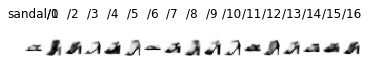

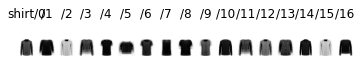

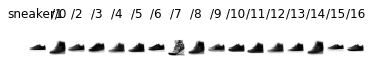

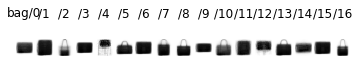

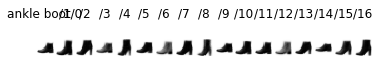

***Training a diagonal GMM with K=18 components***
Label 0: 36 iterations, final MLL     34.757
Label 1: 39 iterations, final MLL     43.301
Label 2: 39 iterations, final MLL     33.640
Label 3: 39 iterations, final MLL     36.845
Label 4: 39 iterations, final MLL     35.628
Label 5: 39 iterations, final MLL     29.178
Label 6: 39 iterations, final MLL     33.038
Label 7: 23 iterations, final MLL     42.425
Label 8: 39 iterations, final MLL     23.762
Label 9: 39 iterations, final MLL     33.261
K=18: acc train 80.78, acc val 78.90


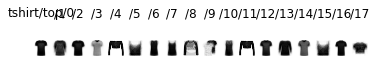

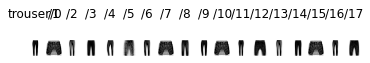

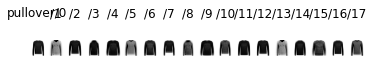

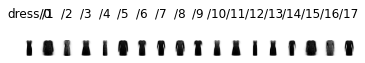

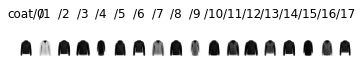

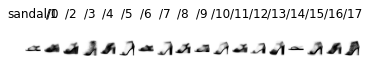

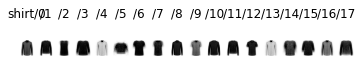

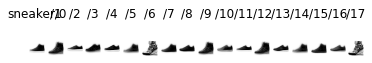

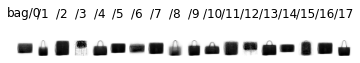

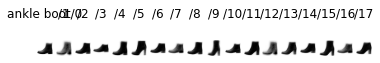

***Training a diagonal GMM with K=19 components***
Label 0: 38 iterations, final MLL     34.755
Label 1: 31 iterations, final MLL     43.525
Label 2: 39 iterations, final MLL     33.852
Label 3: 39 iterations, final MLL     37.212
Label 4: 39 iterations, final MLL     35.670
Label 5: 39 iterations, final MLL     29.391
Label 6: 39 iterations, final MLL     33.354
Label 7: 39 iterations, final MLL     42.470
Label 8: 39 iterations, final MLL     24.354
Label 9: 39 iterations, final MLL     33.166
K=19: acc train 81.08, acc val 79.50


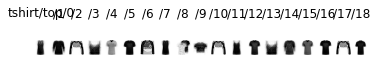

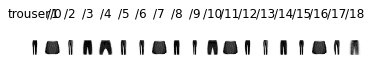

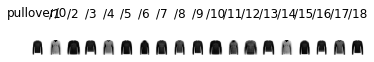

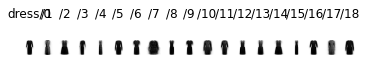

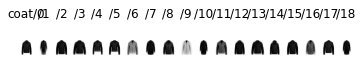

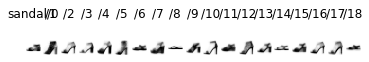

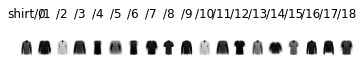

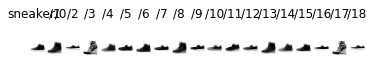

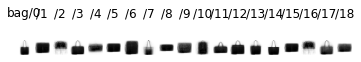

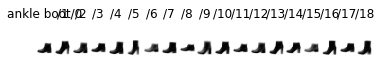

***Training a diagonal GMM with K=20 components***
Label 0: 32 iterations, final MLL     35.127
Label 1: 28 iterations, final MLL     43.346
Label 2: 39 iterations, final MLL     33.871
Label 3: 39 iterations, final MLL     37.017
Label 4: 39 iterations, final MLL     35.346
Label 5: 39 iterations, final MLL     29.352
Label 6: 39 iterations, final MLL     33.254
Label 7: 26 iterations, final MLL     42.672
Label 8: 37 iterations, final MLL     24.532
Label 9: 33 iterations, final MLL     33.385
K=20: acc train 80.86, acc val 79.09


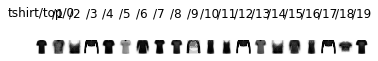

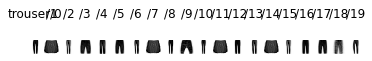

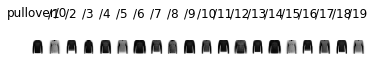

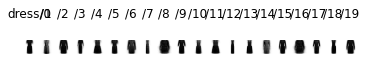

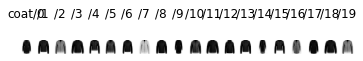

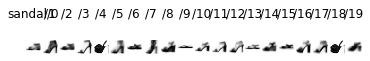

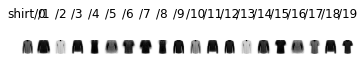

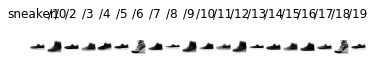

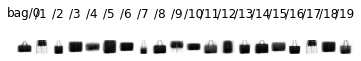

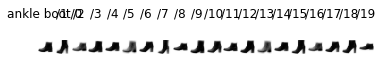

In [ ]:
set_seed(0)
smoothing = 0.1
acc_train_diag = np.zeros(20)
acc_val_diag = np.zeros(20)
for num_components in range(1,21):
  print('***Training a diagonal GMM with K={:d} components***'.format(num_components))
  models = []
  for y in range(data_train.num_labels):
    model = GMM(data_train.dim, num_components, diag=True)
    trainer = GMMTrainerEM(model, smoothing=smoothing)
    models.append(model)
    mll, iteration = trainer.train(data_train.partition[y], num_iterations_max=40, verbose=False)
    print('Label {:d}: {:2d} iterations, final MLL {:10.3f}'.format(y, iteration, mll))
  acc_train, _ = compute_accuracy(models, data_train)
  acc_val, _ = compute_accuracy(models, data_val)
  acc_train_diag[num_components-1] = acc_train
  acc_val_diag[num_components-1] = acc_val
  print('K={:d}: acc train {:3.2f}, acc val {:3.2f}'.format(num_components, acc_train, acc_val))
  for y in range(10):
    show_means(models, y)
    plt.show()
  # print(acc_val_diag)

## <font color=red>Question</font>
For GMMs with diagonal covariance matrices, report
- $K=1$: train acc, val acc
- $K=3$: train acc, val acc

## <font color=red>Answer</font>
- $K=1$: 
         train acc = 67.83
         val acc = 67.47
- $K=3$:
         train acc = 73.98
         val acc = 73.28

# Experiments with Full-Covariance GMMs

Similarly we will train full-covariance GMMs for various $K$ values. Again, the training is pretty sensitive to the smoothing parameter. In fact, the marginal log-likelihood may take positive values (invalid!!!) due to numerical instability, but we can still do classification with the model.

***Training a full-covariance GMM with K=1 components***
Label 0:  1 iterations, final MLL    351.134
Label 1:  1 iterations, final MLL    470.375
Label 2:  1 iterations, final MLL    368.576
Label 3:  1 iterations, final MLL    384.042
Label 4:  1 iterations, final MLL    377.258
Label 5:  1 iterations, final MLL    313.707
Label 6:  1 iterations, final MLL    328.058
Label 7:  1 iterations, final MLL    438.907
Label 8:  1 iterations, final MLL    264.302
Label 9:  1 iterations, final MLL    349.155
K=1: acc train 76.28, acc val 74.05


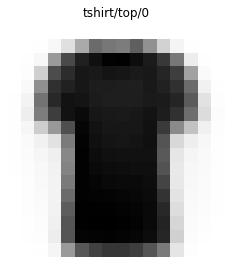

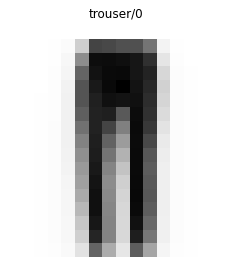

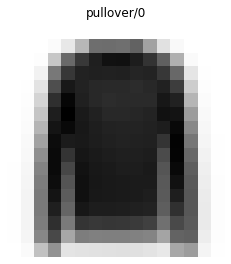

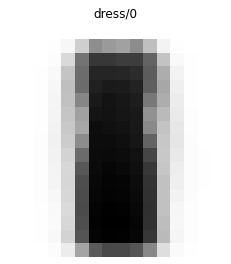

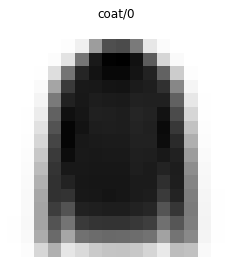

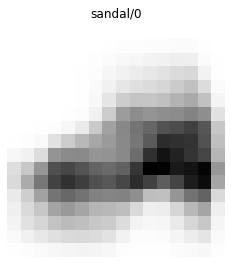

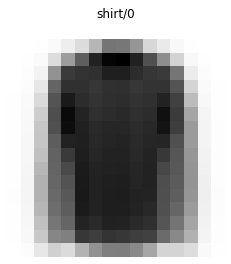

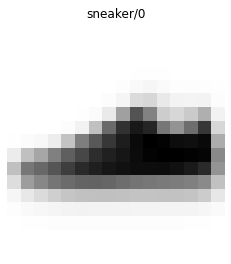

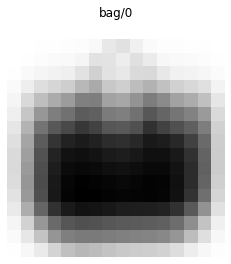

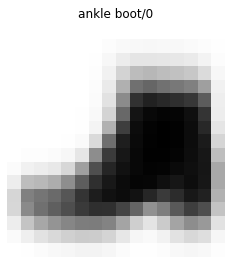

***Training a full-covariance GMM with K=2 components***
Label 0:  2 iterations, final MLL    359.746
Label 1:  3 iterations, final MLL    477.370
Label 2: 20 iterations, final MLL    398.716
Label 3: 39 iterations, final MLL    409.336
Label 4: 13 iterations, final MLL    396.397
Label 5: 27 iterations, final MLL    374.041
Label 6: 39 iterations, final MLL    363.563
Label 7:  2 iterations, final MLL    447.868
Label 8: 18 iterations, final MLL    299.440
Label 9: 27 iterations, final MLL    387.301
K=2: acc train 84.97, acc val 81.30


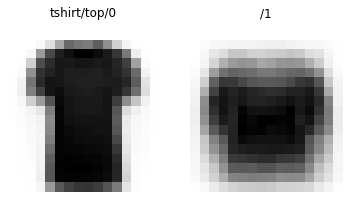

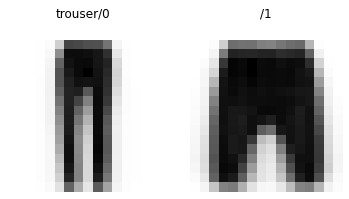

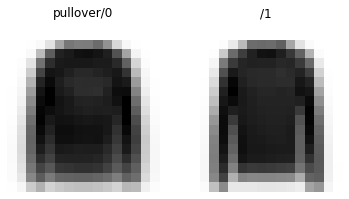

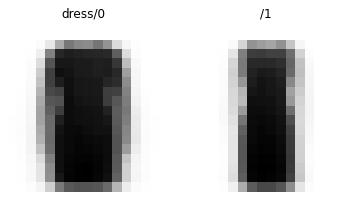

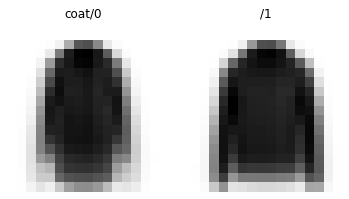

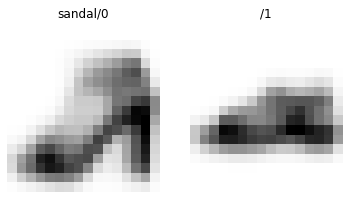

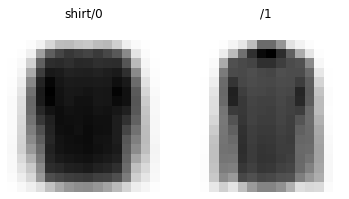

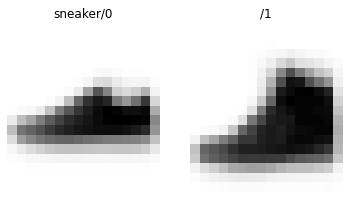

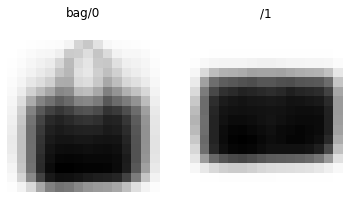

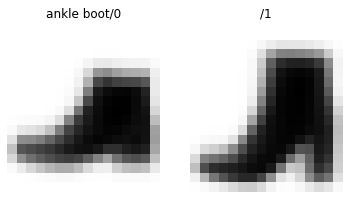

***Training a full-covariance GMM with K=3 components***
Label 0: 23 iterations, final MLL    379.584
Label 1: 17 iterations, final MLL    500.898
Label 2: 16 iterations, final MLL    409.635
Label 3: 20 iterations, final MLL    422.164
Label 4: 31 iterations, final MLL    409.712
Label 5: 30 iterations, final MLL    377.871
Label 6: 39 iterations, final MLL    358.368
Label 7: 39 iterations, final MLL    466.757
Label 8: 29 iterations, final MLL    313.490
Label 9: 25 iterations, final MLL    395.398
K=3: acc train 84.57, acc val 79.86


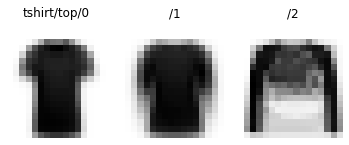

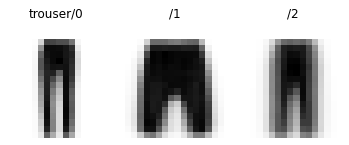

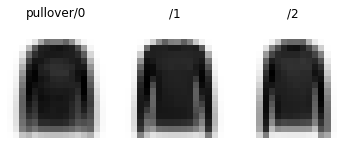

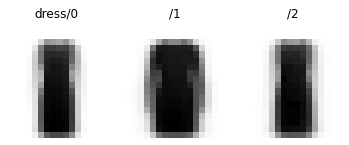

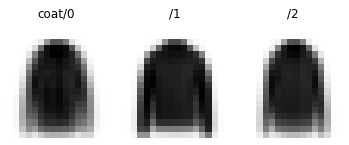

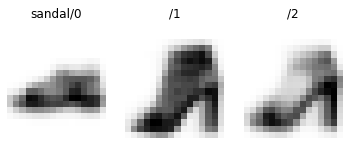

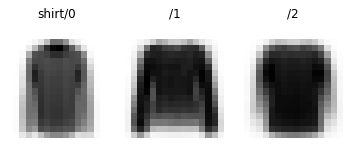

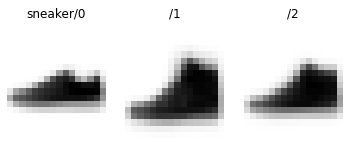

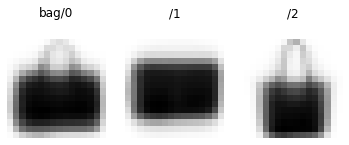

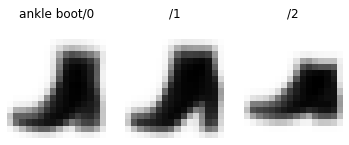

***Training a full-covariance GMM with K=4 components***
Label 0: 23 iterations, final MLL    381.829
Label 1: 12 iterations, final MLL    502.648
Label 2: 15 iterations, final MLL    418.843
Label 3: 10 iterations, final MLL    424.233
Label 4: 34 iterations, final MLL    412.053
Label 5: 23 iterations, final MLL    381.301
Label 6: 30 iterations, final MLL    381.889
Label 7: 15 iterations, final MLL    470.147
Label 8: 39 iterations, final MLL    316.968
Label 9: 29 iterations, final MLL    396.252
K=4: acc train 86.89, acc val 81.53


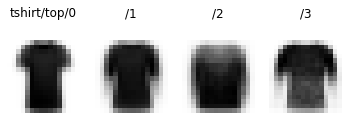

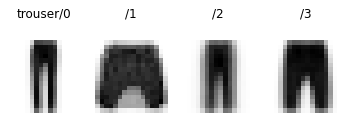

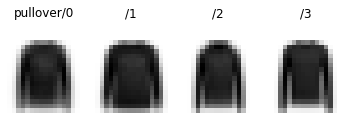

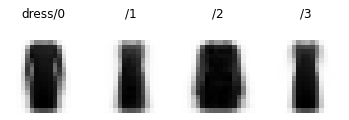

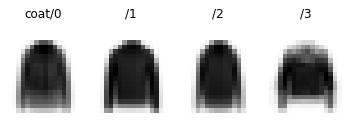

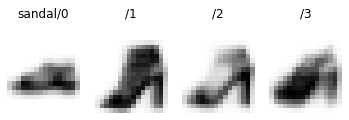

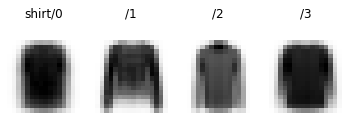

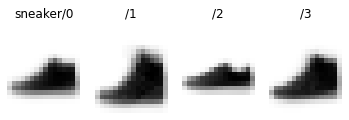

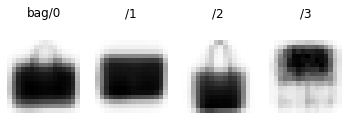

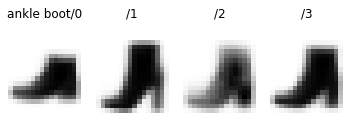

***Training a full-covariance GMM with K=5 components***
Label 0: 16 iterations, final MLL    402.116
Label 1: 20 iterations, final MLL    506.062
Label 2: 18 iterations, final MLL    419.239
Label 3: 12 iterations, final MLL    428.896
Label 4: 39 iterations, final MLL    416.764
Label 5: 35 iterations, final MLL    384.515
Label 6: 17 iterations, final MLL    389.994
Label 7: 13 iterations, final MLL    474.122
Label 8: 39 iterations, final MLL    330.470
Label 9: 36 iterations, final MLL    410.895
K=5: acc train 89.73, acc val 83.53


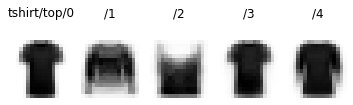

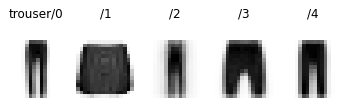

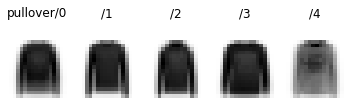

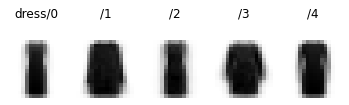

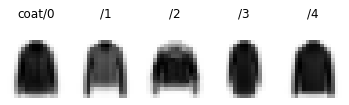

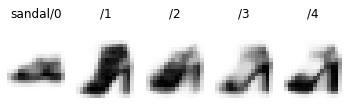

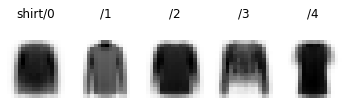

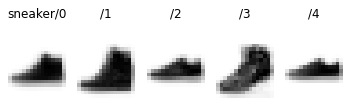

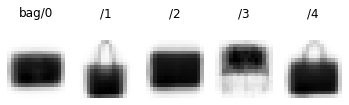

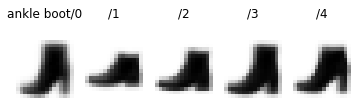

***Training a full-covariance GMM with K=6 components***
Label 0: 39 iterations, final MLL    402.834
Label 1: 16 iterations, final MLL    507.211
Label 2: 34 iterations, final MLL    420.648
Label 3: 20 iterations, final MLL    434.800
Label 4: 34 iterations, final MLL    422.407
Label 5: 11 iterations, final MLL    392.604
Label 6: 31 iterations, final MLL    392.126
Label 7: 15 iterations, final MLL    476.478
Label 8: 15 iterations, final MLL    344.264
Label 9:  7 iterations, final MLL    411.268
K=6: acc train 90.82, acc val 84.09


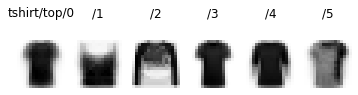

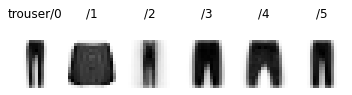

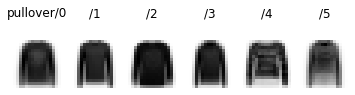

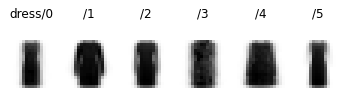

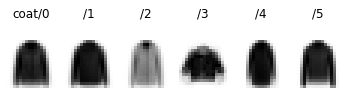

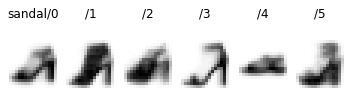

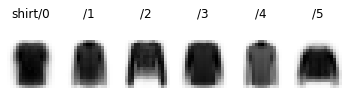

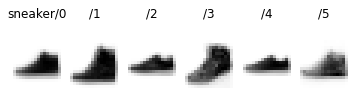

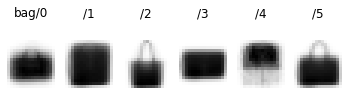

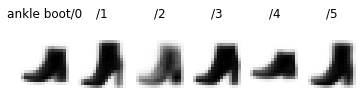

***Training a full-covariance GMM with K=7 components***
Label 0: 33 iterations, final MLL    406.867
Label 1: 14 iterations, final MLL    509.885
Label 2: 27 iterations, final MLL    429.001
Label 3: 34 iterations, final MLL    440.169
Label 4: 32 iterations, final MLL    423.822
Label 5: 10 iterations, final MLL    401.807
Label 6: 18 iterations, final MLL    396.388
Label 7: 13 iterations, final MLL    480.606
Label 8: 12 iterations, final MLL    348.633
Label 9: 15 iterations, final MLL    416.948
K=7: acc train 91.58, acc val 84.41


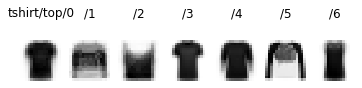

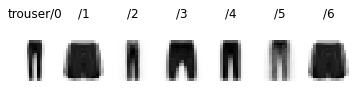

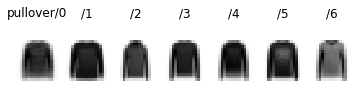

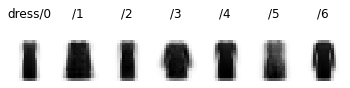

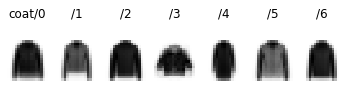

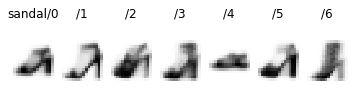

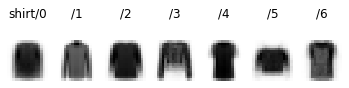

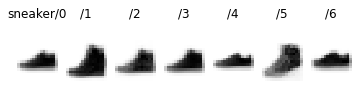

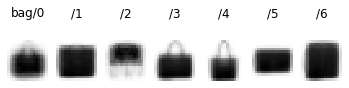

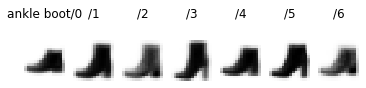

***Training a full-covariance GMM with K=8 components***
Label 0: 18 iterations, final MLL    408.994
Label 1: 22 iterations, final MLL    511.713
Label 2: 30 iterations, final MLL    426.086
Label 3: 27 iterations, final MLL    436.723
Label 4: 39 iterations, final MLL    430.344
Label 5:  7 iterations, final MLL    400.210
Label 6: 20 iterations, final MLL    399.293
Label 7:  9 iterations, final MLL    482.225
Label 8: 24 iterations, final MLL    347.167
Label 9: 19 iterations, final MLL    423.893
K=8: acc train 91.92, acc val 84.45


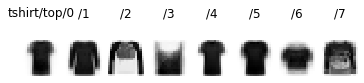

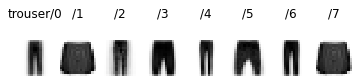

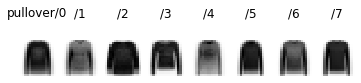

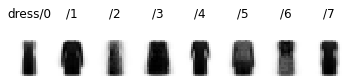

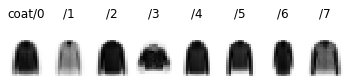

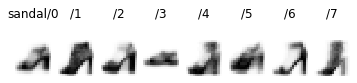

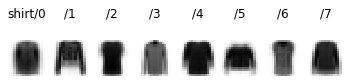

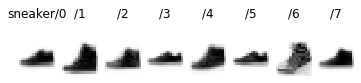

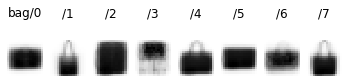

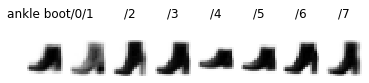

***Training a full-covariance GMM with K=9 components***
Label 0: 24 iterations, final MLL    414.180
Label 1: 11 iterations, final MLL    515.743
Label 2: 20 iterations, final MLL    431.198
Label 3: 16 iterations, final MLL    449.751
Label 4: 28 iterations, final MLL    431.362
Label 5:  6 iterations, final MLL    411.499
Label 6: 21 iterations, final MLL    404.613
Label 7: 12 iterations, final MLL    485.568
Label 8: 12 iterations, final MLL    355.542
Label 9: 21 iterations, final MLL    418.642
K=9: acc train 92.63, acc val 84.66


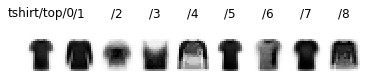

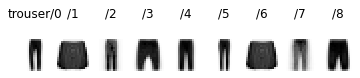

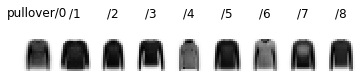

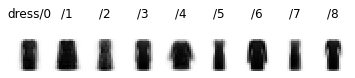

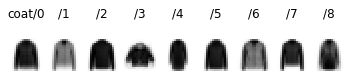

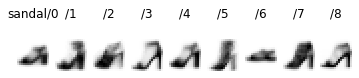

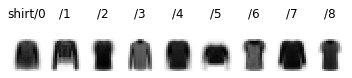

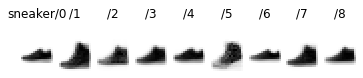

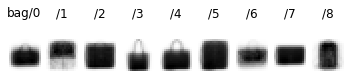

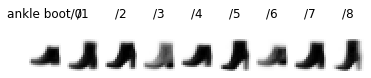

***Training a full-covariance GMM with K=10 components***
Label 0: 14 iterations, final MLL    417.240
Label 1: 27 iterations, final MLL    516.427
Label 2: 23 iterations, final MLL    429.655
Label 3: 28 iterations, final MLL    451.414
Label 4: 24 iterations, final MLL    433.370
Label 5: 21 iterations, final MLL    417.067
Label 6: 15 iterations, final MLL    408.478
Label 7: 20 iterations, final MLL    485.880
Label 8: 20 iterations, final MLL    358.969
Label 9: 14 iterations, final MLL    426.827
K=10: acc train 93.64, acc val 85.42


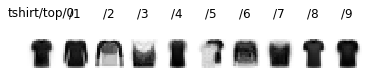

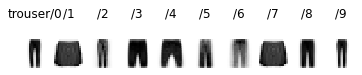

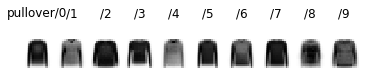

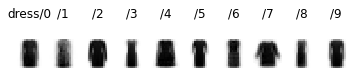

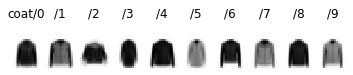

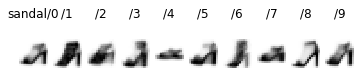

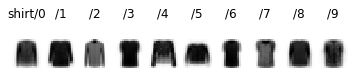

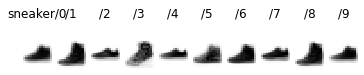

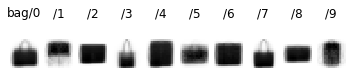

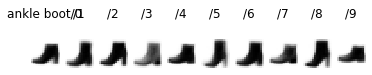

***Training a full-covariance GMM with K=11 components***
Label 0: 15 iterations, final MLL    420.984
Label 1: 22 iterations, final MLL    515.744
Label 2: 17 iterations, final MLL    432.344
Label 3: 25 iterations, final MLL    450.067
Label 4: 19 iterations, final MLL    434.659
Label 5: 25 iterations, final MLL    417.849
Label 6: 14 iterations, final MLL    412.224
Label 7: 11 iterations, final MLL    485.159
Label 8:  9 iterations, final MLL    366.138
Label 9: 23 iterations, final MLL    429.987
K=11: acc train 93.32, acc val 85.15


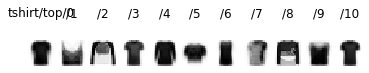

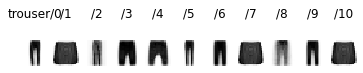

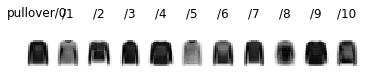

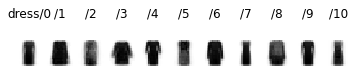

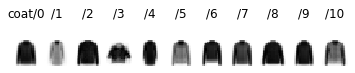

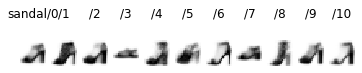

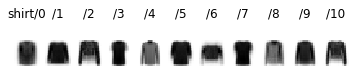

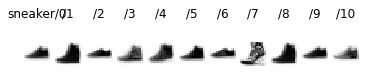

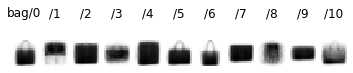

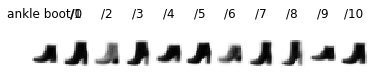

***Training a full-covariance GMM with K=12 components***
Label 0: 32 iterations, final MLL    424.356
Label 1: 19 iterations, final MLL    518.199
Label 2: 37 iterations, final MLL    436.713
Label 3: 39 iterations, final MLL    455.602
Label 4: 21 iterations, final MLL    439.136
Label 5: 14 iterations, final MLL    417.787
Label 6: 24 iterations, final MLL    413.218
Label 7: 22 iterations, final MLL    488.397
Label 8: 19 iterations, final MLL    370.160
Label 9: 22 iterations, final MLL    433.998
K=12: acc train 93.76, acc val 84.35


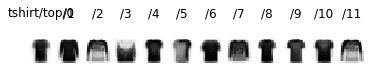

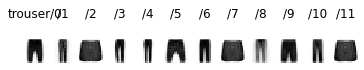

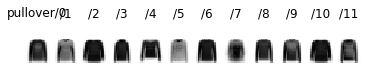

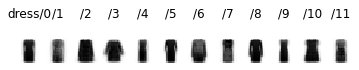

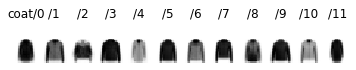

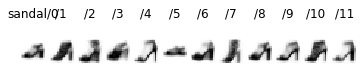

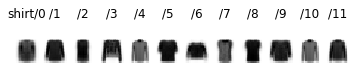

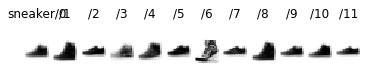

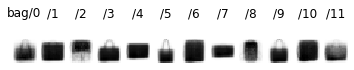

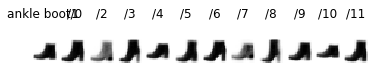

***Training a full-covariance GMM with K=13 components***
Label 0: 13 iterations, final MLL    425.127
Label 1: 14 iterations, final MLL    520.056
Label 2: 31 iterations, final MLL    444.044
Label 3: 12 iterations, final MLL    452.181
Label 4: 29 iterations, final MLL    440.137
Label 5: 24 iterations, final MLL    424.569
Label 6: 16 iterations, final MLL    417.856
Label 7: 20 iterations, final MLL    488.489
Label 8: 20 iterations, final MLL    372.907
Label 9: 20 iterations, final MLL    435.936
K=13: acc train 94.60, acc val 85.66


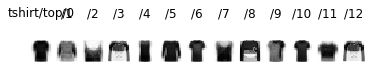

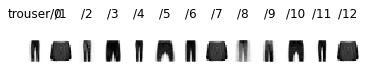

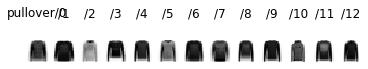

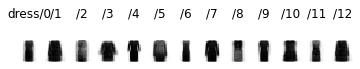

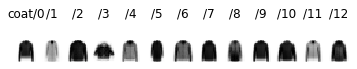

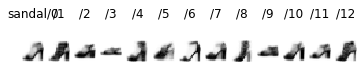

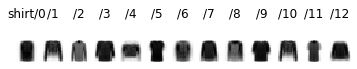

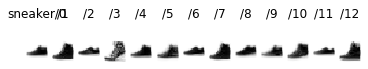

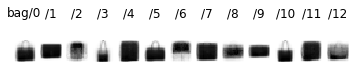

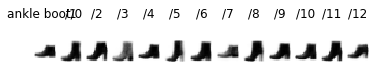

***Training a full-covariance GMM with K=14 components***
Label 0: 22 iterations, final MLL    425.411
Label 1: 29 iterations, final MLL    523.937
Label 2: 29 iterations, final MLL    443.751
Label 3: 16 iterations, final MLL    456.697
Label 4: 27 iterations, final MLL    440.812
Label 5: 22 iterations, final MLL    424.956
Label 6: 24 iterations, final MLL    419.199
Label 7: 19 iterations, final MLL    491.334
Label 8: 16 iterations, final MLL    374.969
Label 9: 13 iterations, final MLL    434.206
K=14: acc train 94.46, acc val 84.43


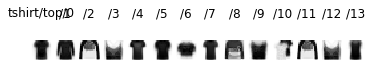

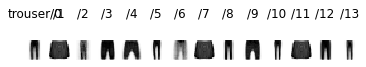

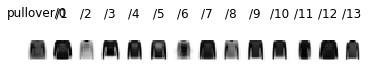

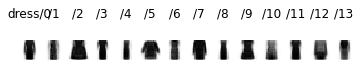

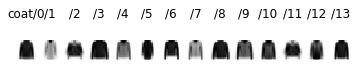

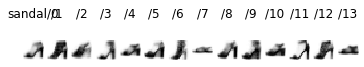

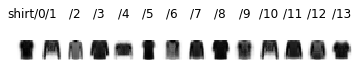

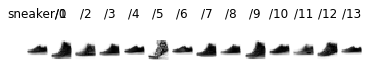

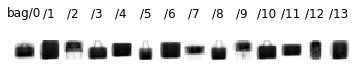

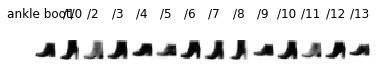

***Training a full-covariance GMM with K=15 components***
Label 0: 19 iterations, final MLL    429.366
Label 1: 15 iterations, final MLL    523.541
Label 2: 31 iterations, final MLL    445.299
Label 3: 16 iterations, final MLL    459.605
Label 4: 29 iterations, final MLL    443.549
Label 5: 19 iterations, final MLL    426.200
Label 6: 20 iterations, final MLL    423.243
Label 7: 20 iterations, final MLL    489.147
Label 8: 29 iterations, final MLL    380.069
Label 9: 32 iterations, final MLL    439.548
K=15: acc train 95.19, acc val 85.48


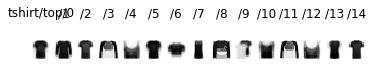

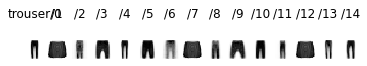

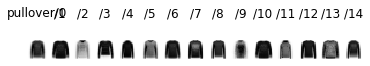

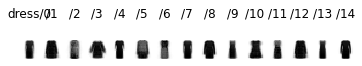

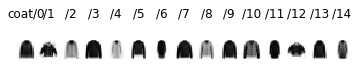

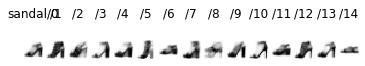

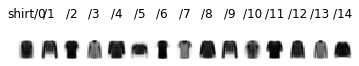

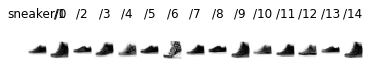

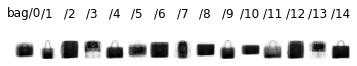

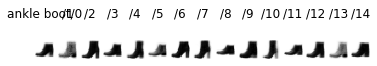

***Training a full-covariance GMM with K=16 components***
Label 0: 16 iterations, final MLL    428.495
Label 1: 12 iterations, final MLL    520.909
Label 2: 32 iterations, final MLL    443.961
Label 3: 29 iterations, final MLL    462.592
Label 4: 39 iterations, final MLL    446.500
Label 5: 33 iterations, final MLL    427.895
Label 6: 25 iterations, final MLL    422.238
Label 7: 13 iterations, final MLL    490.920
Label 8: 17 iterations, final MLL    382.687
Label 9: 28 iterations, final MLL    439.706
K=16: acc train 95.40, acc val 85.53


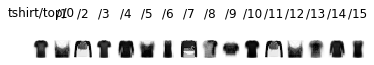

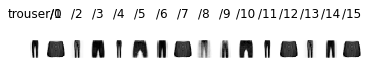

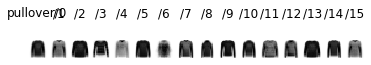

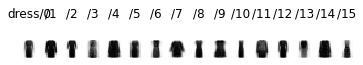

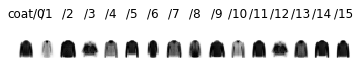

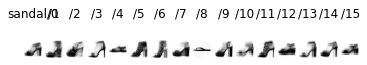

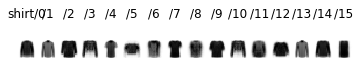

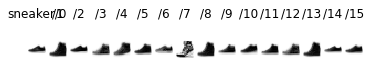

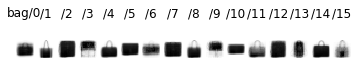

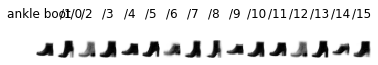

***Training a full-covariance GMM with K=17 components***
Label 0: 22 iterations, final MLL    431.942
Label 1: 22 iterations, final MLL    522.621
Label 2: 20 iterations, final MLL    441.211
Label 3: 16 iterations, final MLL    459.532
Label 4: 24 iterations, final MLL    445.833
Label 5: 16 iterations, final MLL    427.811
Label 6: 31 iterations, final MLL    422.745
Label 7: 20 iterations, final MLL    491.708
Label 8: 20 iterations, final MLL    381.167
Label 9: 11 iterations, final MLL    441.063
K=17: acc train 94.47, acc val 84.27


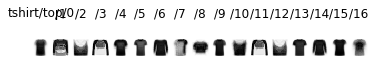

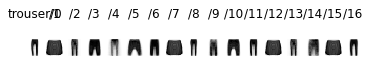

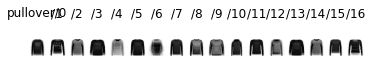

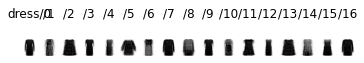

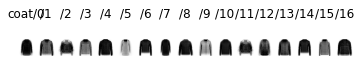

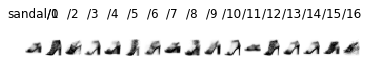

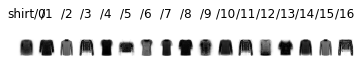

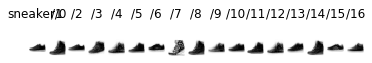

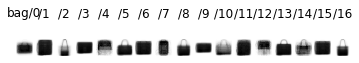

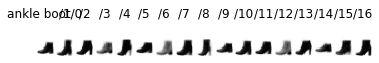

***Training a full-covariance GMM with K=18 components***
Label 0: 29 iterations, final MLL    433.276
Label 1:  7 iterations, final MLL    519.837
Label 2: 24 iterations, final MLL    446.901
Label 3: 26 iterations, final MLL    462.035
Label 4: 37 iterations, final MLL    447.912
Label 5: 20 iterations, final MLL    429.527
Label 6: 29 iterations, final MLL    425.997
Label 7: 20 iterations, final MLL    491.889
Label 8: 20 iterations, final MLL    383.669
Label 9: 35 iterations, final MLL    441.996
K=18: acc train 94.70, acc val 84.74


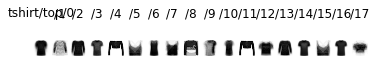

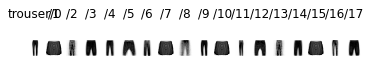

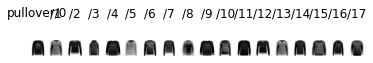

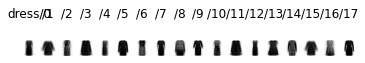

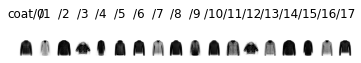

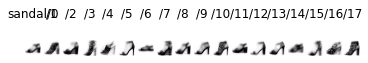

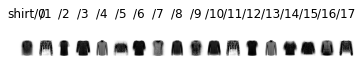

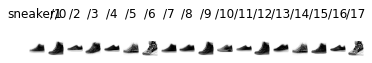

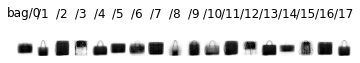

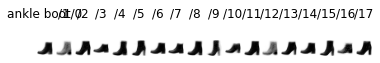

***Training a full-covariance GMM with K=19 components***
Label 0: 11 iterations, final MLL    436.626
Label 1: 16 iterations, final MLL    523.705
Label 2: 31 iterations, final MLL    448.628
Label 3: 25 iterations, final MLL    463.914
Label 4: 24 iterations, final MLL    449.121
Label 5: 16 iterations, final MLL    426.412
Label 6: 39 iterations, final MLL    427.255
Label 7: 21 iterations, final MLL    490.415
Label 8: 12 iterations, final MLL    382.362
Label 9: 22 iterations, final MLL    441.900
K=19: acc train 94.96, acc val 84.18


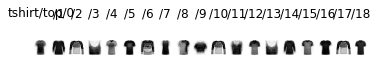

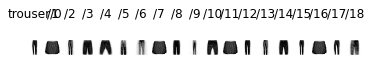

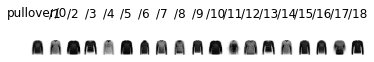

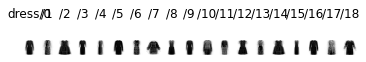

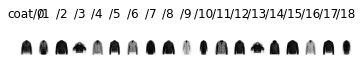

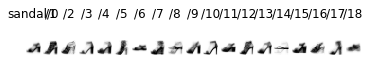

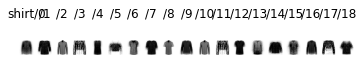

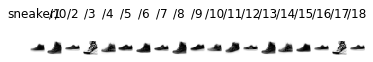

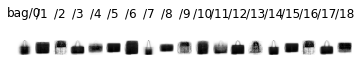

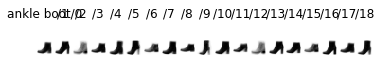

***Training a full-covariance GMM with K=20 components***
Label 0: 17 iterations, final MLL    431.039
Label 1: 12 iterations, final MLL    525.874
Label 2: 27 iterations, final MLL    450.091
Label 3: 25 iterations, final MLL    463.582
Label 4: 28 iterations, final MLL    447.847
Label 5: 39 iterations, final MLL    432.583
Label 6: 16 iterations, final MLL    429.700
Label 7: 24 iterations, final MLL    493.833
Label 8: 36 iterations, final MLL    387.552
Label 9: 38 iterations, final MLL    441.090
K=20: acc train 95.23, acc val 84.72


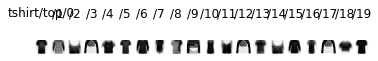

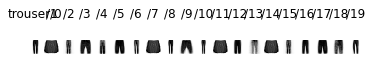

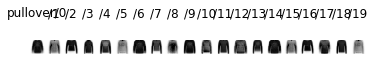

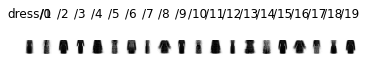

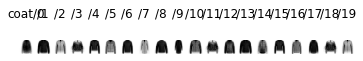

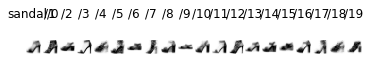

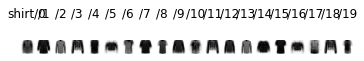

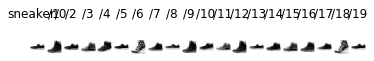

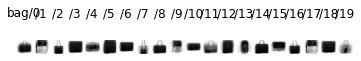

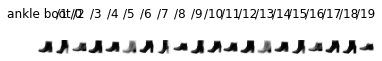

In [ ]:
set_seed(0)
smoothing = 0.001
acc_train_ndiag = np.zeros(20)
acc_val_ndiag = np.zeros(20)
for num_components in range(1,21):
  print('***Training a full-covariance GMM with K={:d} components***'.format(num_components))
  models = []
  for y in range(data_train.num_labels):
    model = GMM(data_train.dim, num_components, diag=False)
    trainer = GMMTrainerEM(model, smoothing=smoothing)
    models.append(model)
    mll, iteration = trainer.train(data_train.partition[y], num_iterations_max=40, verbose=False)
    print('Label {:d}: {:2d} iterations, final MLL {:10.3f}'.format(y, iteration, mll))
  acc_train, _ = compute_accuracy(models, data_train)
  acc_val, _ = compute_accuracy(models, data_val)
  acc_train_ndiag[num_components-1] = acc_train
  acc_val_ndiag[num_components-1] = acc_val 
  print('K={:d}: acc train {:3.2f}, acc val {:3.2f}'.format(num_components, acc_train, acc_val))
  for y in range(10):
    show_means(models, y)
    plt.show()
  # print("train is ", acc_train_ndiag)

## <font color=red>Question</font>
For GMMs with full covariance matrices, report
- $K=1$: train acc, val acc
- $K=3$: train acc, val acc

## <font color=red>Answer</font>
write your answer here
- $K=1$:
  train acc: 76.28
  val acc: 74.05
- $K=3$:
  train acc: 84.57
  val acc: 79.86

---

## <font color=red>Question</font>
Explore the model space with different settings: varying number of components across classes (required), covariance matrix restrictions (required), initialization of GMM, convergence criteria of training, etc
- Report the setting and val accuracy of your single **best model**.
- Describe (in detail) the **trend in accuracies** (train and val) across settings
- Describe (in detail) the **trend in visualized cluster** (displayed by the showMeans function) across settings


## <font color=red>Answer</font>
- The best model is full-covariance with K=13, and val accuracy is 85.66
- As shown in graph
  - diagonal train accuracy: increase to around K=11, and then start to oscillating
  - diagonal val accuracy: increase to around K=11, and then start to oscillating
  - covariance train accuracy: reach a local max at K=2, and continue to increase to around K=13, and then start to oscillating
  - covariance val accuracy: reach a local max at K=2, and continue to increase to around K=5, and then start to osciallting
  - In general, the accuracy follows a descending order of nondiagonal train acc, nondiagonal val acc, diagonal train acc, and diagonal val acc.
- ***trend in visualized cluster***
  - In the early stage of K increasing such as 1 to 3,  the new mean looks drastically different from the previous ones. As K increases to a certain degree such as 10 and up, duplicate pick of mean starts to show up and it is harder to tell the difference of new mean from the old ones, i.e. there is almost always some old means similar to new.
  - Diagonal and covariance model at each K pick different new mean in general. Hard to tell which is better from the graph

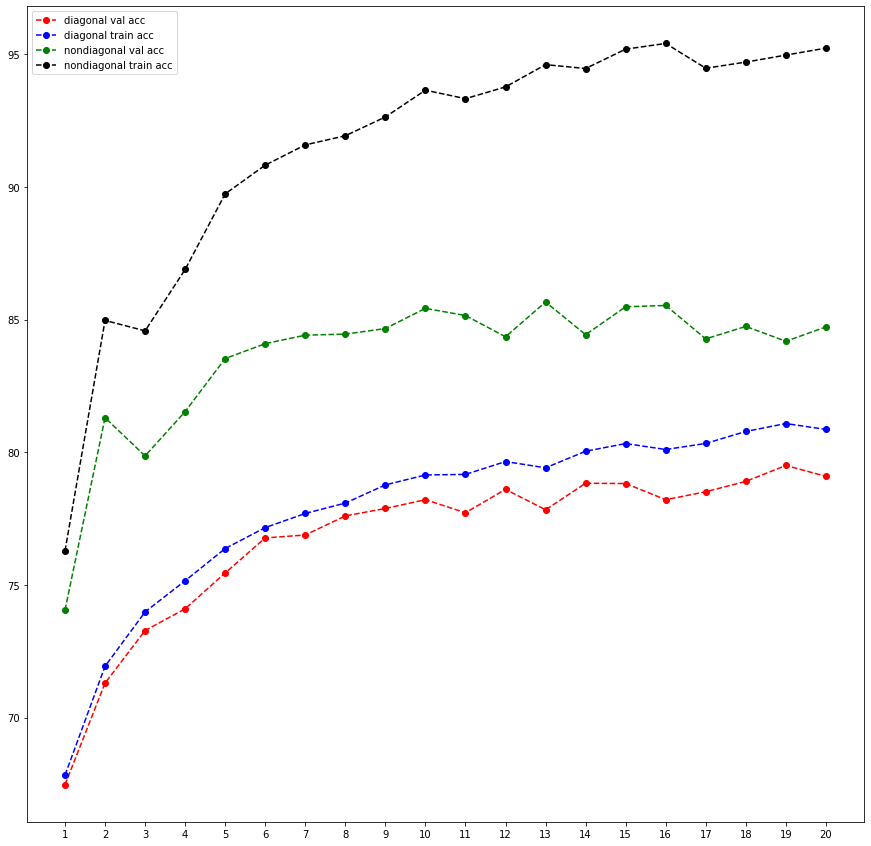

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(np.arange(1,21), acc_val_diag, color='r', linestyle='--', marker='o', label = "diagonal val acc")
plt.plot(np.arange(1,21), acc_train_diag, color='b', linestyle='--', marker='o', label = "diagonal train acc")
plt.plot(np.arange(1,21), acc_val_ndiag, color='g', linestyle='--', marker='o', label = "nondiagonal val acc")
plt.plot(np.arange(1,21), acc_train_ndiag, color='k', linestyle='--', marker='o', label = "nondiagonal train acc")
plt.xticks(range(1,21,1))
plt.legend(loc='upper left')
# max = np.amax(acc_val_ndiag)
# print(max, np.where(acc_val_ndiag == max))